# 實驗摘要
本實驗重點在對台灣智慧財產局商標圖案進行多標籤作圖像辨識。通過針對深度學習模型進行調整和設計，計算圖片對應 79 種各類別標籤的概率，以 mean Average Precision 作為比較指標，最終在測試資料集上進行測試。
而在模型訓練上這次主要使用了 PyTorch 框架進行訓練，並選擇了 EfficientNet-B3 作為基礎模型。資料集來自 Hugging Face，包含商標圖像及其對應的多標籤。初始訓練時將這些訓練資料切分為訓練集和驗證集，並進行了圖像預處理。

# 資料集準備


1.   從 Hugging Face 下載資料集並解壓縮。
2.   讀取標籤對應文件 label_to_idx.txt，並將其轉換為字典格式。
3.   定義自訂的 MultiLabelDataset 類別來加載資料集，並進行圖像預處理。這部分原先有針對圖像進行不同角度翻轉、色彩改變等等的作法，但後續實驗上發現在訓練過程收斂的效果不佳，故最後僅只對圖片進行大小尺寸剪取的預處理。
4.   有將原本的訓練資料進行分割，將資料集分為訓練集 (80%) 和驗證集 (20%)，並使用DataLoader 來讀取訓練集和驗證集。

In [1]:
# 下載資料集
!huggingface-cli download dodofk/ntusldl2024_miniproject_2 --repo-type dataset --local-dir my_dataset

In [ ]:
import os
import tarfile
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from torch.cuda.amp import GradScaler, autocast

In [ ]:
# 解壓縮資料集
def extract_tar_file(tar_path, extract_path):
    if not os.path.exists(extract_path):
        with tarfile.open(tar_path, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"{tar_path} 解壓縮至 {extract_path}")
    else:
        print(f"{extract_path} 資料夾已存在")

extract_tar_file("my_dataset/train_data.tar.gz", "train_data")
extract_tar_file("my_dataset/test_data.tar.gz", "test_data")

my_dataset/train_data.tar.gz 解壓縮至 train_data 資料夾
my_dataset/test_data.tar.gz 解壓縮至 test_data 資料夾


In [ ]:
# 資料轉換與影像前處理
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 自定義資料集
class MultiLabelDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_to_idx, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.label_to_idx = label_to_idx
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert("RGB")

        labels = self.data.iloc[idx, 1].split(',')
        label_tensor = torch.zeros(len(self.label_to_idx))
        for label in labels:
            label_tensor[self.label_to_idx[label.strip()]] = 1.0

        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# 讀取 label_2_idx.txt
label_to_idx = {}
with open('my_dataset/label_to_idx.txt', 'r') as f:
    for line in f:
        label, idx = line.strip().split()
        label_to_idx[label] = int(idx)

# 讀取資料集
dataset = MultiLabelDataset(
    csv_file='my_dataset/train_data.csv',
    root_dir='train_data/train_data',
    label_to_idx=label_to_idx,
    transform=transform_train
)

# 分割訓練集和驗證集
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

val_dataset.dataset.transform = transform_val_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# 模型設計


1.   定義 MultiLabelEfficientNet class，使用已經預訓練好的 EfficientNet-B3 模型來進行微調，同時為了避免在訓練過程的 overfitting 問題，有添加 Dropout 層，並在最後調整全連接層以適應本次多標籤任務。
2.   模型選擇上，有先使用 resnet18、resnet50、resnet101、EfficientNet-B0 進行實驗，最終選用 EfficientNet-B0 的進階模型 EfficientNet-B3。



In [ ]:
# 使用預訓練模型
class MultiLabelEfficientNet(nn.Module):
    def __init__(self, num_labels):
        super(MultiLabelEfficientNet, self).__init__()
        self.efficientnet = models.efficientnet_b3(pretrained=True)
        self.efficientnet.classifier[1] = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(self.efficientnet.classifier[1].in_features, num_labels)
        )

    def forward(self, x):
        x = self.efficientnet(x)
        return x

model = MultiLabelEfficientNet(num_labels=len(label_to_idx)).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 205MB/s]


# 模型訓練


1.   本次為加快模型的訓練速度，比較沒有利用驗證集再針對 batch size、learning rate、weight decay 等重要的超參數進行探索，如果要改進模型表現可以再針對這方面進行調整。
2.   設定 batch size 為 32，損失函數為 BCEWithLogitsLoss，優化器為 AdamW (lr=1e-4)，同時為了避免 overfitting 的問題有另外添加 weight decay (1e-4) 正則化的機制，並使用 ReduceLROnPlateau 來動態進行學習率調整。
3.   使用自動混合精度 (AMP) 加快訓練過程。
4.   設置 early stopping 機制 (epoch = 30、patience = 5)，當驗證集的 mAP 不再提升時提前停止訓練。
5.   Train Loss: 0.0044、Val Loss: 0.0622、Val mAP: 0.6226。


In [ ]:
# 設定損失函數與優化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

scaler = GradScaler()

def calculate_map(y_true, y_pred):
    return average_precision_score(y_true, y_pred, average='macro')

# 模型訓練
num_epochs = 30
early_stopping_patience = 5
best_val_map = 0
patience_counter = 0

train_losses = []
val_losses = []
val_maps = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0.0
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            all_labels.append(labels.cpu().numpy())
            all_outputs.append(outputs.cpu().numpy())

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    all_labels = np.vstack(all_labels)
    all_outputs = np.vstack(all_outputs)

    val_map = calculate_map(all_labels, all_outputs)
    val_maps.append(val_map)

    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f} - Val mAP: {val_map:.4f}")

    if val_map > best_val_map:
        best_val_map = val_map
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1

    scheduler.step(val_map)

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered.")
        break

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
<ipython-input-6-070254ac8dd6>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/30 - Train Loss: 0.1011 - Val Loss: 0.0802 - Val mAP: 0.1501


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 2/30 - Train Loss: 0.0651 - Val Loss: 0.0691 - Val mAP: 0.2555


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 3/30 - Train Loss: 0.0552 - Val Loss: 0.1169 - Val mAP: 0.3419


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 4/30 - Train Loss: 0.0477 - Val Loss: 0.0485 - Val mAP: 0.3970


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 5/30 - Train Loss: 0.0415 - Val Loss: 0.0460 - Val mAP: 0.4404


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 6/30 - Train Loss: 0.0362 - Val Loss: 0.0561 - Val mAP: 0.4697


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 7/30 - Train Loss: 0.0317 - Val Loss: 0.0448 - Val mAP: 0.4943


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 8/30 - Train Loss: 0.0278 - Val Loss: 0.0569 - Val mAP: 0.5173


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 9/30 - Train Loss: 0.0245 - Val Loss: 0.0455 - Val mAP: 0.5396


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 10/30 - Train Loss: 0.0217 - Val Loss: 0.0465 - Val mAP: 0.5485


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 11/30 - Train Loss: 0.0195 - Val Loss: 0.0472 - Val mAP: 0.5596


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 12/30 - Train Loss: 0.0174 - Val Loss: 0.0475 - Val mAP: 0.5717


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 13/30 - Train Loss: 0.0158 - Val Loss: 0.0491 - Val mAP: 0.5765


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 14/30 - Train Loss: 0.0144 - Val Loss: 0.0500 - Val mAP: 0.5836


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 15/30 - Train Loss: 0.0132 - Val Loss: 0.0513 - Val mAP: 0.5845


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 16/30 - Train Loss: 0.0119 - Val Loss: 0.0521 - Val mAP: 0.5947


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 17/30 - Train Loss: 0.0110 - Val Loss: 0.0530 - Val mAP: 0.6055


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 18/30 - Train Loss: 0.0103 - Val Loss: 0.0550 - Val mAP: 0.6015


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 19/30 - Train Loss: 0.0095 - Val Loss: 0.0555 - Val mAP: 0.6104


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 20/30 - Train Loss: 0.0090 - Val Loss: 0.0560 - Val mAP: 0.6109


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 21/30 - Train Loss: 0.0084 - Val Loss: 0.0571 - Val mAP: 0.6143


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 22/30 - Train Loss: 0.0078 - Val Loss: 0.0574 - Val mAP: 0.6131


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 23/30 - Train Loss: 0.0074 - Val Loss: 0.0586 - Val mAP: 0.6099


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 24/30 - Train Loss: 0.0071 - Val Loss: 0.0599 - Val mAP: 0.6136


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 25/30 - Train Loss: 0.0058 - Val Loss: 0.0594 - Val mAP: 0.6212


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 26/30 - Train Loss: 0.0050 - Val Loss: 0.0613 - Val mAP: 0.6184


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 27/30 - Train Loss: 0.0047 - Val Loss: 0.0619 - Val mAP: 0.6200


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 28/30 - Train Loss: 0.0046 - Val Loss: 0.0624 - Val mAP: 0.6216


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 29/30 - Train Loss: 0.0044 - Val Loss: 0.0622 - Val mAP: 0.6226


<ipython-input-6-070254ac8dd6>:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 30/30 - Train Loss: 0.0041 - Val Loss: 0.0634 - Val mAP: 0.6203


In [ ]:
# 儲存模型
torch.save(model.state_dict(), 'without valid model.pth')

# 下載檔案
from google.colab import files
files.download('without valid model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 視覺化訓練過程


1.   Training Loss、Validation Loss、mAP 在 30 epochs 的變化。
2.   之前觀察大概都會在第 10 次 epoch 後有過擬合的現象，雖然 mAP 表現還是會有滿大繼續提升的空間，但還是有因此在之前的訓練過程中加入正則化機制來提升模型的泛化能力。



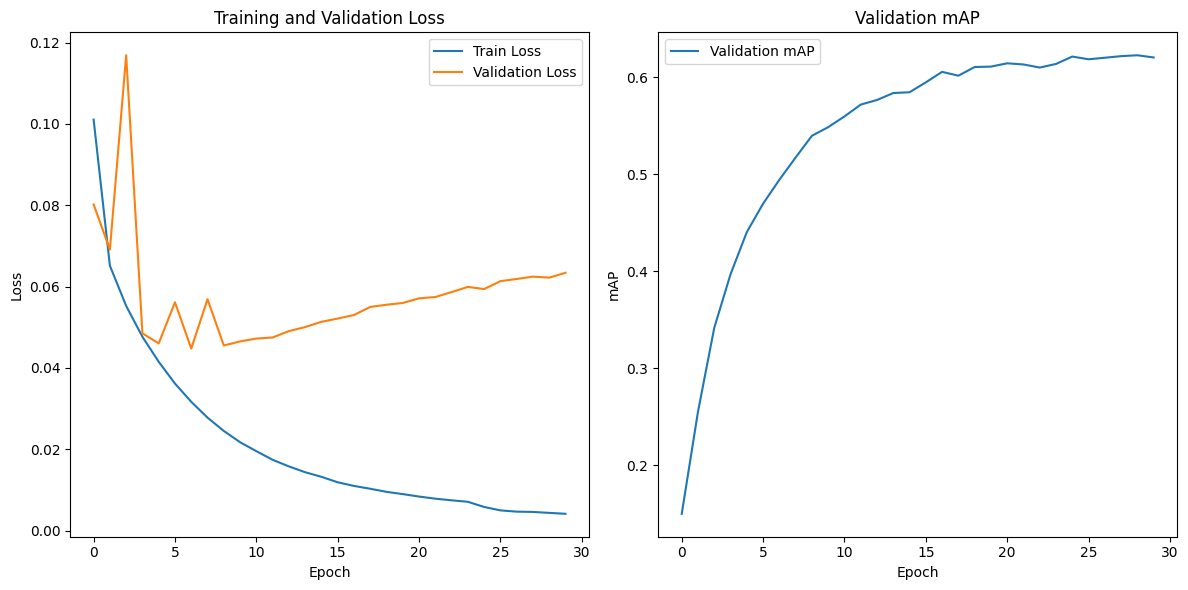

In [ ]:
# 視覺化訓練過程
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_maps, label='Validation mAP')
plt.xlabel('Epoch')
plt.ylabel('mAP')
plt.legend()
plt.title('Validation mAP')

plt.tight_layout()
plt.show()

# 最終訓練


1.   最終有將訓練集與驗證集結合在一起，利用全部的資料重新訓練一次。
2.   因為是使用前面訓練好的最佳模型再進行調整，這裡設定 epoch = 15，patience = 3。
3.   Train Loss: 0.0030。



In [ ]:
# 合併訓練集與驗證集
full_train_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_train_loader = DataLoader(full_train_dataset, batch_size=64, shuffle=True)

# 讀取前面訓練好最好的模型
model.load_state_dict(torch.load("best_model.pth"))

# 使用全部的訓練集進行最後的訓練
num_final_epochs = 15
final_optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
final_scheduler = ReduceLROnPlateau(final_optimizer, mode='max', factor=0.5, patience=2, verbose=True)

final_early_stopping_patience = 3
final_best_train_loss = float('inf')
final_patience_counter = 0

for epoch in range(num_final_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in full_train_loader:
        images, labels = images.to(device), labels.to(device)

        final_optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(final_optimizer)
        scaler.update()

        running_loss += loss.item()

    train_loss = running_loss / len(full_train_loader)
    print(f"Final Epoch {epoch+1}/{num_final_epochs} - Train Loss: {train_loss:.4f}")

    if train_loss < final_best_train_loss:
        final_best_train_loss = train_loss
        final_patience_counter = 0
        torch.save(model.state_dict(), "final_model.pth")
    else:
        final_patience_counter += 1

    final_scheduler.step(train_loss)

    if final_patience_counter >= final_early_stopping_patience:
        print("Final early stopping triggered.")
        break

# 儲存最終的模型
torch.save(model.state_dict(), "final_model.pth")

<ipython-input-9-4306dd653290>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))
/usr/local/lib/python3.10/dist-packages/t

Final Epoch 1/15 - Train Loss: 0.0145
Final Epoch 2/15 - Train Loss: 0.0100
Final Epoch 3/15 - Train Loss: 0.0080
Final Epoch 4/15 - Train Loss: 0.0068
Final Epoch 5/15 - Train Loss: 0.0054
Final Epoch 6/15 - Train Loss: 0.0048
Final Epoch 7/15 - Train Loss: 0.0043
Final Epoch 8/15 - Train Loss: 0.0040
Final Epoch 9/15 - Train Loss: 0.0037
Final Epoch 10/15 - Train Loss: 0.0036
Final Epoch 11/15 - Train Loss: 0.0033
Final Epoch 12/15 - Train Loss: 0.0032
Final Epoch 13/15 - Train Loss: 0.0032
Final Epoch 14/15 - Train Loss: 0.0030
Final Epoch 15/15 - Train Loss: 0.0030


In [ ]:
# 下載最終的模型
files.download("final_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 模型訓練


1.   自訂 CustomTestDataset Class 來讀取測試集。
2.   使用訓練好的模型對測試集進行預測，並將結果保存為 CSV 文件。
3.   Kaggle Public Score (mAP): 0.67619。


In [ ]:
# 自訂測試資料集 (僅返回圖片)
class CustomTestDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_name = self.data.iloc[idx, 0]
        image_path = f"{self.root_dir}/{image_name}"
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [ ]:
# 測試集檔案前處理
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 讀取測試資料集
test_dataset = CustomTestDataset(
    csv_file='my_dataset/test_data_public.csv',
    root_dir='test_data/test_data',
    transform=transform
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 進行預測
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        predictions.append(outputs.cpu().numpy())  # 收集預測結果

predictions = np.vstack(predictions)

# 儲存為 CSV 文件
output = pd.DataFrame(predictions, columns=[f'class_{i}_prob' for i in range(79)])
output['filename'] = test_dataset.data['filename']
output = output[['filename'] + [f'class_{i}_prob' for i in range(79)]]

output.to_csv('submission.csv', index=False)

In [ ]:
# 下載 CSV 檔案
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>